## Prediction of alcohol consumption in Moskow
### Authors: Mikołaj Szopa, Bartosz Trynda
Main goal of this project is to analyse and try to make a prediction of alcohol consumption pre capita based of pre years values.\

### The data
The data used in this project comes mainly for kaggle webstite https://www.kaggle.com/datasets/dwdkills/alcohol-consumption-in-russia \
Data set contains values of consumption of different types of alcohols i.e. beer, vodka, wine etc. durig 18 years between 1998 and 2016.\
For the project consumption of clear alcohol was needed, so some calculation were required. Moreover the data set was extended by additional\
GDP per Capita data found on The World Bank website https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=RU .

To check prediciotion reference value of 2017 was used that equals 11.19 litre per capita


In [1067]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [1024]:
DATA_2017=11.19
data_mos = pd.read_csv('Moskwa.csv',sep=';')
data_years=data_mos['year'].to_numpy()
data_values=data_mos['alcohol'].to_numpy()
data_gdp=data_mos['GDP_per_capita'].to_numpy()
zeros=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]


Data presentation

In [1025]:
data_mos.head()

,year,region,wine,beer,vodka,champagne,brandy,alcohol,GDP_per_capita
0,1998,Moscow,6.8,30.0,18.9,3.5,0.7,10.63,1834.9
1,1999,Moscow,6.6,56.0,18.7,3.6,0.7,11.83,1330.8
2,2000,Moscow,6.3,61.8,18.8,3.9,0.6,12.12,1771.6
3,2001,Moscow,5.0,78.9,19.7,4.2,0.7,13.24,2100.4
4,2002,Moscow,4.8,85.7,20.8,4.0,0.9,14.05,2377.5


Text(0.5, 1.0, 'Alcohol consumption in Moskow')

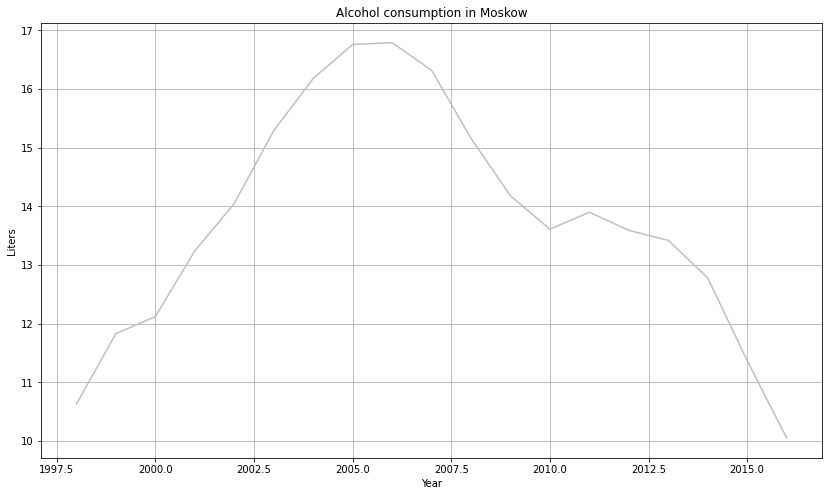

In [1026]:
fig = plt.figure(figsize=(14,8))
plt.grid(True)
plt.grid
plt.plot(data_years,data_values,color='0.75')
plt.xlabel('Year')
plt.ylabel('Liters')
plt.title('Alcohol consumption in Moskow')

In [ ]:
Looking at the data it is clear that the consumption of alohol is decreasing over the year and had it's maximum around 2006.\

The question is, if this trend is realted to something i.e. GDP or is it more or less random.

To find this out two models were chosen:\
1. normal: *value = normal($\mu$,$\sigma$)*
2. quadratic regression: *value = normal($\beta$·gdp+$\beta$ _2·gdp^2+$\alpha$,$\sigma$)*

The normal model means that the outcome value is not connected with any porcess and it is simply a randnom value from specific range.\
When you think, about your previous year alcohol consumption rather does not have impact on how much you drink this year. It worth checking.

The second model with quadratic equation assumes that the consumption rise along side with gdp but when the sociaty is wealthy enougth,\
it spends its money of other things than alcohol. The second level of polynomial was chosen as linear one which was tested before did not\
fit to data.

### Normal model
For our model some prior had to be chosen. As we do not know what are typical values for alcohol consumption we made had\
to pick priors by trial.

Assuming that:\
1. a beer(500ml) contains 22,5 ml of alcohol
2. a glass of wine (175ml) contains 21 ml of alcohol
3. a glass of vodka (50ml) contains 20 ml of alcohol

Lets imagine a normal peroson that drinks beer five times a week, and to times a week wine to dinner. That gives us 116,5 ml\
of alcohol per week. In addition lets assume that the same person once a month goes to party and drinks 10 shots of vodka.\
It gives us around 11 liters of alcohol per year. As we know we are calcualting valeus for people in Russia so lets add additional\
1,5 litre to out value.

We also have to think that some people might go to party twice a month and some will go to one every two month or more rarely.\
Taking all of this into consideration we end up with mean value of 12,5 and variance of 2,5

In [1033]:
with open('normal_pre.stan','r') as file:
    print(file.read())

generated quantities {
   real mu = normal_rng(12.5,2.5);
   real sigma = fabs(normal_rng(0,0.6));
   real alcohol =  normal_rng(mu, sigma);
}


In [1034]:
model_normal = CmdStanModel(stan_file='normal_pre.stan')

INFO:cmdstanpy:compiling stan file C:\Users\mjszo\OneDrive\Pulpit\stan\normal_pre.stan to exe file C:\Users\mjszo\OneDrive\Pulpit\stan\normal_pre.exe
INFO:cmdstanpy:compiled model executable: C:\Users\mjszo\OneDrive\Pulpit\stan\normal_pre.exe


In [1035]:
samp_model1 = model_normal.sample(iter_sampling=1000, iter_warmup=0, chains=1, fixed_param=True, seed=22042020,refresh=1000)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [1036]:
mu_sim=samp_model1.stan_variable('mu')
sigma_sim=samp_model1.stan_variable('sigma')
alcohol=samp_model1.stan_variable('alcohol')
az.summary(samp_model1,var_names=['mu','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,12.54,2.51,7.88,17.27
sigma,0.48,0.34,0.00,1.10


Having generated samples from prior model we can print them alongside with out data to see weather we choose\
good parameters for values. On the chart below generated samples are compared to real data (red dots)\
Is seems that the prior parameters have been chosen correctly

Text(0.5, 1.0, '$\\sigma$')

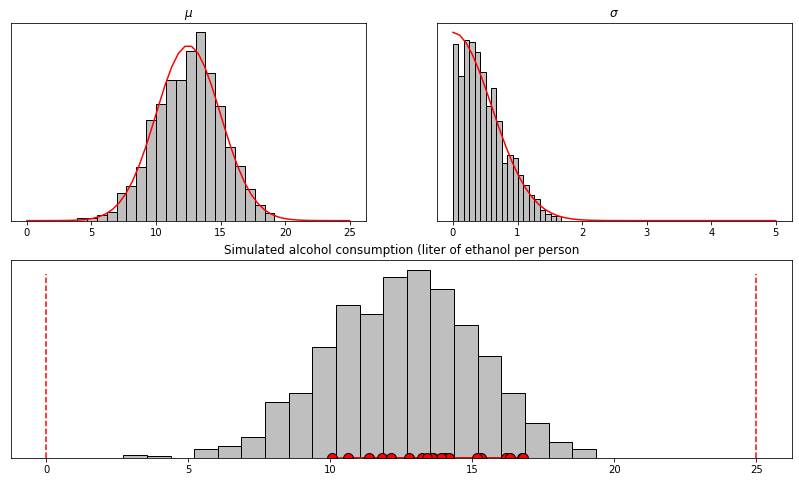

In [1038]:
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(alcohol,bins=20,color='0.75',edgecolor='k',density=True)
ax1.vlines([0,25],ymin=0,ymax=15e-2,linestyle='--',color='r',zorder=1)
ax1.set_yticks([])
ax1.set_title('Simulated alcohol consumption (liter of ethanol per person')
ax1.plot(data_values,zeros,color='r',markeredgecolor='k',markersize=20,marker='.',zorder=2,label='Data')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax2.set_yticks([])
ax2.hist(mu_sim,bins=20,color='0.75',edgecolor='k',density=True)
x=np.linspace(0,25)
y=stats.norm.pdf(x,loc=12.5,scale=2.5)
ax2.plot(x,y,'r')
ax2.set_title('$\mu$')
ax2.set_yticks([])
ax3.set_yticks([])

ax3.hist(sigma_sim,bins=20,color='0.75',edgecolor='k',density=True)
x=np.linspace(0,5)
y=stats.halfnorm.pdf(x,loc=0,scale=0.6)
ax3.plot(x,y,'r')
ax3.set_title('$\sigma$')


The samples from prior are displayed on one plot with actual data(red dots). From the plot we can assume that the prior\
was chosen properly and we can go to next step of analysis

### POSTERIOR - normal model

In [1043]:
fit_normal = CmdStanModel(stan_file='normal_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [1044]:
data = dict(N=len(data_years), alcohol_val=data_values,)

samp_model2 = fit_normal.sample(data=data,seed=29042020)
mu_sim=samp_model2.stan_variable('mu')
sigma_sim=samp_model2.stan_variable('sigma')
alcohol_sim=samp_model2.stan_variable('alcohol')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [1045]:
samp_model2.diagnose()

'Processing csv files: C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\normal_post-20220613181630_1.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\normal_post-20220613181630_2.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\normal_post-20220613181630_3.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\normal_post-20220613181630_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

Having fitted the model with the data diagnose function was has been called. The output of this test point that model and parameters were chosen properly.\
No divergences occures during samplig, the size of effective samples are good and the R-hat values are satisfactory for all parameter

In [1073]:
df=samp_model2.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,alcohol[1],...,log_lik[10],log_lik[11],log_lik[12],log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19]
0,-44.2736,1.000000,0.881645,2.0,3.0,0.0,44.7093,13.4906,1.98578,15.0408,...,-2.62005,-1.95834,-1.66522,-1.60676,-1.62621,-1.60620,-1.60558,-1.66897,-2.17512,-3.10590
1,-45.3979,0.898533,0.881645,2.0,3.0,0.0,45.8031,12.9640,2.04997,13.2004,...,-2.97682,-2.21055,-1.81270,-1.68642,-1.74101,-1.68339,-1.66151,-1.64079,-1.93907,-2.64706
2,-45.7694,0.988626,0.881645,2.0,3.0,0.0,45.9421,12.7908,1.98759,13.4727,...,-3.18224,-2.31627,-1.85011,-1.69079,-1.76157,-1.68670,-1.65597,-1.60588,-1.86137,-2.55664
3,-45.8233,0.912742,0.881645,2.0,3.0,0.0,47.3030,13.4276,2.24910,13.2384,...,-2.55637,-2.02611,-1.78542,-1.73276,-1.75152,-1.73208,-1.72948,-1.77093,-2.14797,-2.85713
4,-44.3392,0.783335,0.881645,1.0,3.0,0.0,49.4975,13.6860,1.56404,13.1139,...,-2.78427,-1.81028,-1.41608,-1.36739,-1.37557,-1.36810,-1.38068,-1.53400,-2.46260,-4.06849


In [1048]:
az.summary(samp_model2,var_names=['mu','sigma','alcohol'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,13.55,0.41,12.78,14.30
sigma,1.81,0.21,1.44,2.24
alcohol[0],13.55,1.94,10.07,17.35
alcohol[1],13.58,1.85,10.27,17.32
alcohol[2],13.55,1.83,10.15,17.02
alcohol[3],13.53,1.87,10.23,17.27
alcohol[4],13.54,1.86,10.26,17.17
alcohol[5],13.55,1.89,10.11,17.14
alcohol[6],13.52,1.86,10.04,16.96
alcohol[7],13.55,1.86,9.94,16.95


Using our model we can try to predict avarage alcohol consumption for following year and compare it to external data for 2017, that is 11.19 litre pre person.\
As you can see below, our model overestimated the value for more than 2 liters, which is not a good result. the good news is that the predicted value is within the confidence interval.

In [1050]:
median_alcohol = np.median(alcohol_sim.flatten())
cinf_alcohol_sim = az.hdi(alcohol_sim.flatten(),0.90)
print('Median fo predicted consumption =', median_alcohol)
print('Confidence interval (90%) = [',*cinf_alcohol_sim,']' )

Median fo predicted consumption = 13.554549999999999
Confidence interval (90%) = [ 10.4727 16.6059 ]


To graphically represent the results, the plot_posterior function from the arviz library was used

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


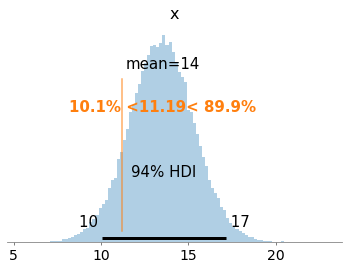

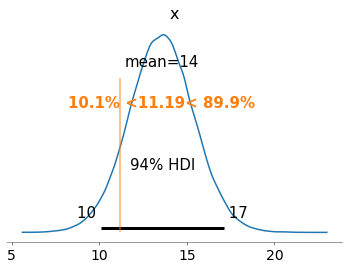

In [1054]:
ax1 = az.plot_posterior(alcohol_sim,round_to=2,kind='hist', bins=100,ref_val=DATA_2017)
ax2 = az.plot_posterior(alcohol_sim,round_to=2,kind='kde', bins=100,ref_val=DATA_2017)

### Quadratic regression model

The next model used for our project is model quadratic regression model

Text(0.5, 1.0, 'Alcohol consumption in Moskow')

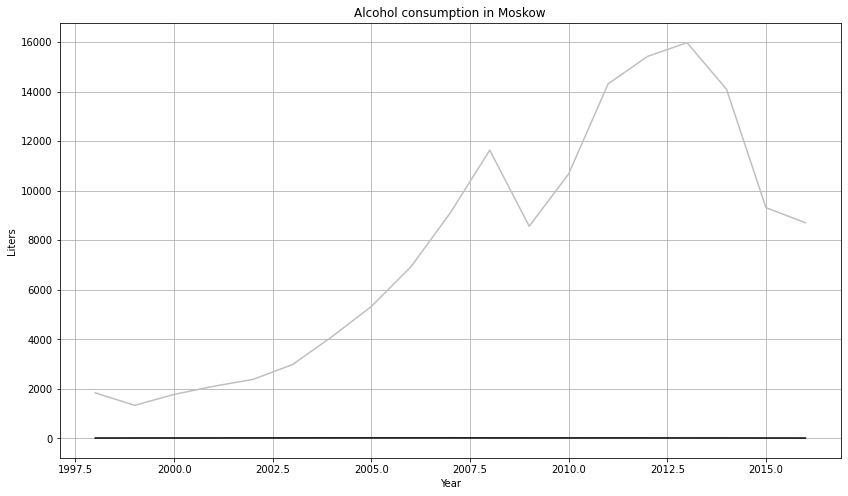

In [1057]:
fig = plt.figure(figsize=(14,8))
plt.grid(True)
plt.grid
plt.plot(data_years,data_gdp,color='0.75')
plt.plot(data_years,data_values,color='k')
plt.xlabel('Year')
plt.ylabel('Liters')
plt.title('Alcohol consumption in Moskow')


In [1074]:
with open('regre_pre.stan','r') as file:
    print(file.read())

data {
    int N;
    real gdp[N];
}

generated quantities {
   real alpha = normal_rng(12,2.5);
   real beta = fabs(normal_rng(0,0.01));
   real beta2 = -fabs(normal_rng(0,1));
   real sigma = fabs(normal_rng(0,0.6));
   real alcohol[N];
   for (i in 1:N){
   alcohol[N] =  normal_rng(gdp[N]*beta+gdp[N]^2*beta2+alpha, sigma);
}}



In [1075]:
model_regre = CmdStanModel(stan_file='regre_pre.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [1076]:
data_ppc={'N':50, 'gdp':np.linspace(0,20000)}
samp_model3 = model_regre.sample(data=data_ppc,iter_sampling=1000, iter_warmup=0, chains=1, fixed_param=True, seed=22042020,refresh=1000)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [1077]:
alpha_sim=samp_model3.stan_variable('alpha')
beta_sim=samp_model3.stan_variable('beta')
beta2_sim=samp_model3.stan_variable('beta2')
sigma_sim=samp_model3.stan_variable('sigma')
alcohol=samp_model3.stan_variable('alcohol')

Some data standarization

In [1078]:
c_gdp=data_gdp-data_gdp.mean()
s_gdp=c_gdp/data_gdp.std()

The points reprezenting alcohol consumption as a function of GPD was plotted alongside samples generated from prior model. As can it be\
seen quadratic model is better then liner one and in some way fits the data

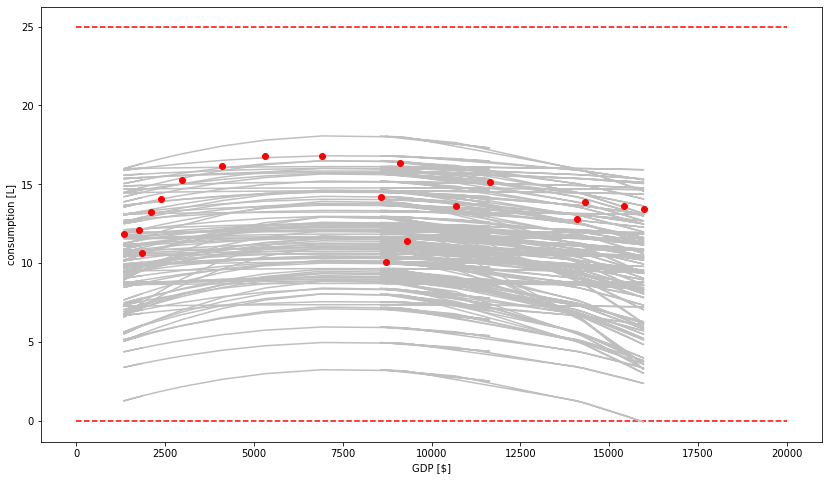

In [1080]:
fig, axes = plt.subplots(1,1,figsize=(14,8))
axes.hlines([0,25],xmin=0,xmax=20000,linestyle='--',color='r')
for i in range(100):
    axes.plot(data_gdp,alpha_sim[i]+beta_sim[i]*s_gdp+beta2_sim[i]*s_gdp*s_gdp,c='0.75')
axes.set_ylabel('consumption [L]')
axes.set_xlabel('GDP [$]')
plt.scatter(data_gdp,data_values,zorder=10,c='r')

The prepared model does not fully match the data but overall trend can be seen.

### POSTERIOR - quadratic model

In [1082]:
with open('regre_post.stan','r') as file:
    print(file.read())

data {
    int N;
    real gdp[N];
    real alcohol_val[N];
}
parameters{
    real alpha;
    real<upper=0> beta;
    real<upper=0> beta2;
    real<lower=0> sigma;
}

transformed parameters {
   vector[N] mu;
   for (i in 1:N){
    mu[i]=gdp[i]*beta+gdp[i]*gdp[i]*beta2+alpha;
   }
}

model{
    alpha ~ normal(12,2.5);
    beta ~ normal(0,0.01);
    beta2 ~ normal(0,1.1);
    sigma ~ normal(0,0.6);
    for (i in 1:N){
    alcohol_val[i] ~ normal(mu[i],sigma); 
}}

generated quantities {
   real alcohol[N];
   real log_lik;
   #log_lik[i] =  normal_lpdf(alcohol_val[i]| mu[i], sigma);
   for (i in 1:N){
    alcohol[i] =  normal_rng(mu[i], sigma);
    log_lik[i] =  normal_lpdf(alcohol_val[i]| mu[i], sigma);
}
}


In [1092]:
fit_regre = CmdStanModel(stan_file='regre_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [1103]:
data = dict(N=len(data_years), gdp=data_gdp, alcohol_val=data_values)
samp_model4 = fit_regre.sample(data=data,seed=29042020)
alpha_sim=samp_model4.stan_variable('alpha')
mu_sim=samp_model4.stan_variable('mu')
beta_sim=samp_model4.stan_variable('beta')
sigma_sim=samp_model4.stan_variable('sigma')
alcohol_sim=samp_model4.stan_variable('alcohol')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [1104]:
samp_model4.diagnose()

'Processing csv files: C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\regre_post-20220613193513_1.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\regre_post-20220613193513_2.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\regre_post-20220613193513_3.csv, C:\\Users\\mjszo\\AppData\\Local\\Temp\\tmpt7zigt82\\regre_post-20220613193513_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

Having fitted the model with the data diagnose function was has been called. The output of this test point that model and parameters were chosen properly.\
No divergences occures during samplig, the size of effective samples are good and the R-hat values are satisfactory for all parameter

In [1105]:
df=samp_model4.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,beta2,...,log_lik[10],log_lik[11],log_lik[12],log_lik[13],log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19]
0,-58.2804,0.769240,0.327691,3.0,15.0,0.0,62.7565,14.1488,-0.000010,-2.583070e-09,...,-2.67007,-1.81265,-1.35730,-1.34041,-1.37639,-1.34660,-1.33854,-1.44567,-2.64714,-4.48960
1,-57.5257,0.997054,0.327691,4.0,15.0,0.0,59.6079,14.3304,-0.000060,-4.278960e-09,...,-2.66972,-2.16690,-1.65667,-1.61921,-1.81552,-1.78259,-1.76383,-1.60075,-2.12952,-3.11595
2,-57.2155,0.995131,0.327691,3.0,7.0,0.0,58.0077,14.4425,-0.000060,-3.438160e-09,...,-2.57323,-2.05075,-1.59884,-1.56948,-1.70714,-1.67297,-1.65492,-1.56648,-2.23970,-3.35741
3,-57.2414,0.953633,0.327691,3.0,7.0,0.0,58.9436,14.5325,-0.000047,-6.299650e-09,...,-2.64940,-2.13897,-1.55760,-1.53134,-1.78570,-1.76604,-1.75291,-1.52193,-2.23328,-3.46819
4,-59.5113,0.780452,0.327691,3.0,11.0,0.0,60.1535,13.9041,-0.000021,-2.065410e-10,...,-2.67230,-1.85290,-1.47065,-1.43047,-1.45154,-1.43093,-1.43159,-1.53990,-2.39547,-3.82892


In [1106]:
az.summary(samp_model4,var_names=['mu','sigma','alcohol'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu[0],14.19,0.49,13.24,15.10
mu[1],14.21,0.50,13.24,15.14
mu[2],14.19,0.50,13.22,15.09
mu[3],14.17,0.49,13.22,15.07
mu[4],14.16,0.49,13.22,15.04
mu[5],14.12,0.48,13.17,14.96
mu[6],14.05,0.46,13.15,14.89
mu[7],13.96,0.44,13.11,14.77
mu[8],13.83,0.43,13.00,14.60
mu[9],13.63,0.42,12.87,14.42


Using our model we can try to predict avarage alcohol consumption for following year and compare it to external data for 2017, that is 11.19 litre pre person.\
Surprisingly the output of the model with regression is almost the same as the output of normal model with slighly wider confidence interval. It might mean that\
there is no relation between GDP and alcohol conusmption.

In [1107]:
median_alcohol = np.median(alcohol_sim)
cinf_alcohol_sim = az.hdi(alcohol_sim.flatten(),0.89)
print('Median fo predicted consumption =', median_alcohol)
print('Confidence interval = [',*cinf_alcohol_sim,']' )
print(DATA_2017)

Median fo predicted consumption = 13.69035
Confidence interval = [ 10.6443 16.7625 ]
11.19


p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\data\base.py:216: UserWarning: More chains (4000) than draws (19). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


<AxesSubplot:title={'center':'x'}>

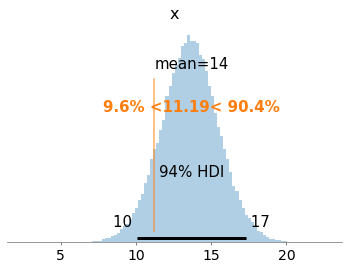

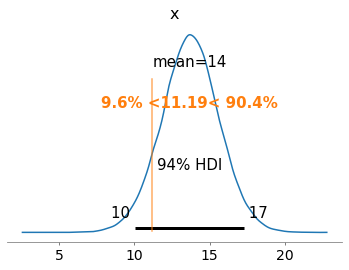

In [1108]:
az.plot_posterior(alcohol_sim,round_to=2,kind='hist', bins=100,ref_val=DATA_2017)
az.plot_posterior(alcohol_sim,round_to=2,kind='kde', bins=100,ref_val=DATA_2017)

### Model comparison

In [1109]:
fit_n=az.from_cmdstanpy(posterior=samp_model2, posterior_predictive='alcohol',log_likelihood='log_lik')
fit_r=az.from_cmdstanpy(posterior=samp_model4, posterior_predictive='alcohol',log_likelihood='log_lik')

In [1110]:
loo_compare = az.compare({'Normal':fit_n,'Regression':fit_r}, 'loo')
loo_compare

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Normal,0,-41.622382,1.691984,0.000000,1.0,3.071663,0.000000,False,log
Regression,1,-42.851461,2.288686,1.229079,0.0,3.237384,1.291287,False,log


In [1111]:
waic_compare = az.compare({'Normal':fit_n,'Regression':fit_r}, 'waic')
waic_compare

p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
p:\Users\mjszo\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Normal,0,-41.599617,1.669219,0.000000,1.000000e+00,3.064054,0.000000,False,log
Regression,1,-42.824494,2.261720,1.224877,1.110223e-16,3.228388,1.283534,True,log


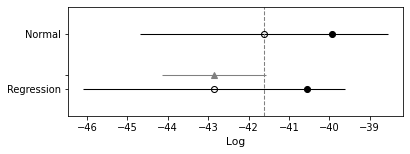

In [1112]:
az.plot_compare(loo_compare)
plt.show()


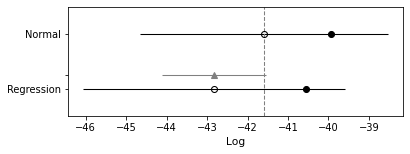

In [1113]:
az.plot_compare(waic_compare)
plt.show()

After plotting the results we can see that outputs of loo and waic criteria are quite similar. What is suprising in both cases the normal model\
better describes the analysed data. The conlusion is that the decreasing cinsumption of alcohol in Moskow is related to some other phenomenas